In [3]:
# Initial imports
import datetime as dt
import hvplot.pandas
import json
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import seaborn as sns
import time

%matplotlib inline

In [4]:
coinbase_api_url = "https://api.pro.coinbase.com"
products_api_url = f"{coinbase_api_url}/products"
currencies_api_url = f"{coinbase_api_url}/currencies"

In [5]:
currencies_response = requests.get(currencies_api_url)
currencies = currencies_response.json()
currencies_df = pd.DataFrame(currencies)
currencies_df = pd.concat([currencies_df, pd.io.json.json_normalize(currencies_df["details"])], axis=1).drop(columns=["details"])
currencies_df.head()

,convertible_to,id,max_precision,message,min_size,name,status,crypto_address_link,crypto_transaction_link,display_name,group_types,max_withdrawal_amount,min_withdrawal_amount,network_confirmations,processing_time_seconds,push_payment_methods,sort_order,symbol,type
0,[],ALGO,0.000001,,1,Algorand,online,https://algoexplorer.io/address/{{address}},https://algoexplorer.io/tx/{{txId}},,[],1000000.0,0.1000,1,5,[crypto],93,A,crypto
1,[],DASH,0.00000001,,1,Dash,online,https://chain.so/address/DASH/{{address}},https://chain.so/tx/DASH/{{address}},,[],10000.0,0.0001,2,0,[crypto],47,,crypto
2,[],OXT,0.00000001,,1,Orchid,online,https://etherscan.io/token/0x4575f41308EC1483f...,https://etherscan.io/tx/0x{{txId}},,[],1000000.0,0.0100,35,0,[crypto],48,,crypto
3,[],ATOM,0.000001,,1,Cosmos,online,https://cosmos.bigdipper.live/account/{{address}},https://cosmos.bigdipper.live/transactions/{{t...,,[],100000.0,0.1000,0,5,[crypto],51,,crypto
4,[],KNC,0.00000001,,1,Kyber Network,online,https://etherscan.io/token/0xdd974d5c2e2928dea...,https://etherscan.io/tx/0x{{txId}},,[],2156253.0,0.0100,35,0,[crypto],120,Ξ,crypto


In [6]:
products_response = requests.get(products_api_url)
products = products_response.json()
products_df = pd.DataFrame(products)
products_df.head()

,base_currency,base_increment,base_max_size,base_min_size,cancel_only,display_name,id,limit_only,margin_enabled,max_market_funds,min_market_funds,post_only,quote_currency,quote_increment,status,status_message,trading_disabled
0,XLM,1.00000000,600000.00000000,1.00000000,False,XLM/BTC,XLM-BTC,False,False,50,0.001,False,BTC,0.00000001,online,,False
1,LOOM,1.00000000,2500000.00000000,1.00000000,False,LOOM/USDC,LOOM-USDC,True,False,100000,0.1,False,USDC,0.00000100,online,,False
2,NU,0.00000100,1300000.00000000,10.00000000,False,NU/USD,NU-USD,False,False,100000,1.0,False,USD,0.00010000,online,,False
3,BAT,1.00000000,800000.00000000,1.00000000,False,BAT/USDC,BAT-USDC,False,False,100000,10,False,USDC,0.00000100,online,,False
4,UMA,0.00100000,4500.00000000,0.01000000,False,UMA/USD,UMA-USD,False,False,100000,1.0,False,USD,0.00100000,online,,False


In [7]:
def get_candle_data(id, start_date):
    start_str = dt.datetime.strftime(start_date, "%Y-%m-%d")
    end_str = dt.datetime.strftime(start_date + dt.timedelta(days=300), "%Y-%m-%d")
    candles_url = f"{products_api_url}/{id}/candles?start={start_str}&end={end_str}&granularity=86400"
    candles_response = requests.get(candles_url)
    candles = candles_response.json()
    candles_df = pd.DataFrame(candles, columns=["time", "low", "high", "open", "close", "volume"])
    return candles_df

In [8]:
base_currency_id = "base_currency"
quote_currency_id = "quote_currency"
crypto_currencies = currencies_df[currencies_df["type"] == "crypto"]["id"].tolist()
fiat_currencies = currencies_df[currencies_df["type"] == "fiat"]["id"].tolist()
fiat_products_df = products_df[products_df[quote_currency_id].isin(fiat_currencies)]

today = dt.datetime.today()
base = dt.datetime.strptime("2009-01-01", "%Y-%m-%d")
delta_days = (today - base).days
iterations = math.floor(delta_days / 300) + 1
date_list = [base + dt.timedelta(days=x*300) for x in range(iterations)]

data_df = pd.DataFrame()
for idx, row in fiat_products_df.iterrows():
    product_id = row["id"]
    base_currency = row[base_currency_id]
    quote_currency = row[quote_currency_id]
    for start_date in date_list:
        df = get_candle_data(product_id, start_date)
        if not df.empty:
            df[base_currency_id] = base_currency
            df[quote_currency_id] = quote_currency
            data_df = data_df.append(df)

In [9]:
print(f"Crypto currencies: {crypto_currencies}")
print(f"Fiat currencies: {fiat_currencies}")

Crypto currencies: ['ALGO', 'DASH', 'OXT', 'ATOM', 'KNC', 'XRP', 'REP', 'MKR', 'CGLD', 'COMP', 'NMR', 'OMG', 'BAND', 'UMA', 'XLM', 'EOS', 'ZRX', 'BAT', 'LOOM', 'UNI', 'YFI', 'LRC', 'CVC', 'DNT', 'MANA', 'GNT', 'REN', 'LINK', 'BTC', 'BAL', 'LTC', 'ETH', 'BCH', 'ETC', 'USDC', 'ZEC', 'XTZ', 'DAI', 'WBTC', 'NU', 'FIL', 'AAVE', 'SNX', 'BNT', 'GRT']
Fiat currencies: ['EUR', 'GBP', 'USD']


In [10]:
# convert epoch time to date
data_df = data_df.drop_duplicates()
data_df["date"] = pd.to_datetime(data_df["time"], unit="s")
data_df = data_df.drop(columns=["time"])

In [11]:
fiat_volume_data_df = pd.concat([data_df[data_df[quote_currency_id] == fiat].groupby(["date"])["volume"].sum() for fiat in fiat_currencies], axis=1)
fiat_volume_data_df.columns = fiat_currencies
fiat_volume_pct_df = fiat_volume_data_df.pct_change()

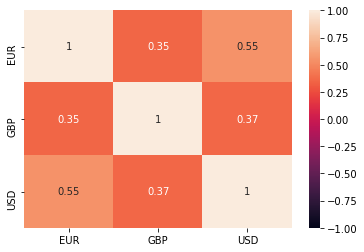

In [40]:
fiat_volume_pct_corr_df = fiat_volume_pct_df.corr(method="pearson")
corr_plot = sns.heatmap(fiat_volume_pct_corr_df, vmin=-1, vmax=1, annot=True)
# corr_plot.figure.savefig("fiat_correlation.png", bbox_inches="tight")

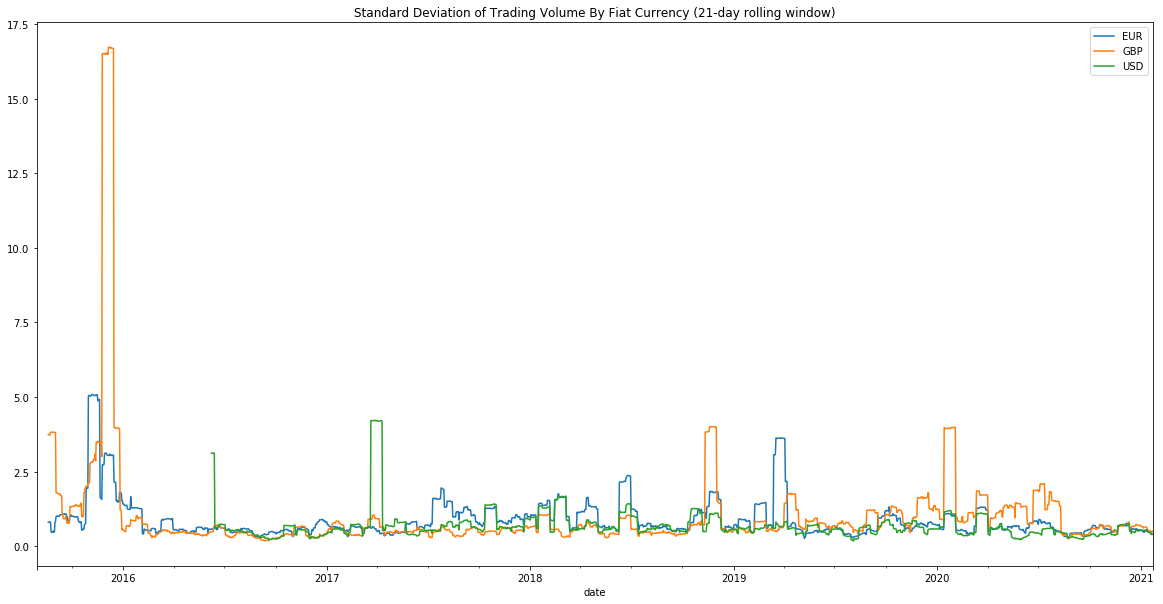

In [39]:
# calculate standard deviation
volume_std = fiat_volume_pct_df.std()

# Calculate rolling standard deviation
rolling_volume_std = fiat_volume_pct_df.rolling(window=21).std()

# Plot rolling standard deviation
ax = rolling_volume_std.plot(figsize=(20,10), title="Standard Deviation of Trading Volume By Fiat Currency (21-day rolling window)")
# ax.figure.savefig("trading_volume_std.png", bbox_inches="tight")

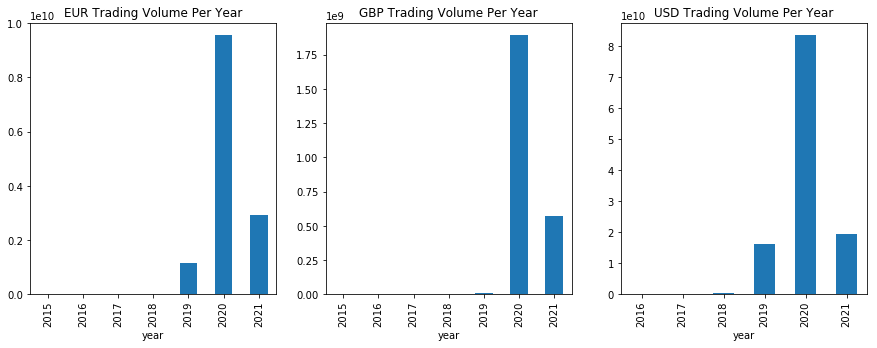

In [37]:
# visualize volume by fiat currency and year
data_df["year"] = data_df["date"].dt.year
fig_year_volume, ax = plt.subplots(ncols=len(fiat_currencies), figsize=(15,5))
for idx, fiat in enumerate(fiat_currencies):
    fiat_year_volume = data_df[data_df[quote_currency_id] == fiat].groupby(["year"])["volume"].sum()
    fiat_year_volume.plot(kind="bar", title=f"{fiat} Trading Volume Per Year", ax=ax[idx])

plt.show()
plt.close(fig_year_volume)

# Save plot as PNG
# plt.savefig("yearly_trading_volume.png", bbox_inches="tight")

In [27]:
# visualize volume by fiat currency
fiat_volume_df = data_df[["date", quote_currency_id, "volume"]].groupby(["date", quote_currency_id]).sum()
fiat_volume_df.hvplot.line(x="date", y="volume", by=quote_currency_id, title="Trading Volume by Fiat Currency", height=500, width=1000)

:NdOverlay   [quote_currency]
   :Curve   [date]   (volume)

In [25]:
# visualize the number of unique traded cryptocurrencies for each fiat currency
crypto_count_df = data_df.groupby(["date", quote_currency_id])[base_currency_id].nunique()
crypto_count_df.hvplot.line(x="date", y=base_currency_id, by=quote_currency_id, title="Count of Unique Cryptocurrencies", height=300, width=1000)

:NdOverlay   [quote_currency]
   :Curve   [date]   (base_currency)

In [22]:
# visualize USD volume by base currency
usd_volume_df = data_df[data_df.quote_currency == "USD"].groupby(["date", base_currency_id])["volume"].sum()
usd_volume_df.hvplot.line(x="date", y="volume", by=base_currency_id, title="USD: Trading Volume of Each Cryptocurrency", height=500, width=1000)

:NdOverlay   [base_currency]
   :Curve   [date]   (volume)

In [23]:
# visualize GBP volume by base currency
gbp_volume_df = data_df[data_df.quote_currency == "GBP"].groupby(["date", base_currency_id])["volume"].sum()
gbp_volume_df.hvplot.line(x="date", y="volume", by=base_currency_id, title="GBP: Trading Volume of Each Cryptocurrency", height=500, width=1000)

:NdOverlay   [base_currency]
   :Curve   [date]   (volume)

In [24]:
# visualize GBP volume by base currency
eur_volume_df = data_df[data_df.quote_currency == "EUR"].groupby(["date", base_currency_id])["volume"].sum()
eur_volume_df.hvplot.line(x="date", y="volume", by=base_currency_id, title="EUR: Trading Volume of Each Cryptocurrency", height=500, width=1000)

:NdOverlay   [base_currency]
   :Curve   [date]   (volume)

In [ ]:
top3_usd = list(data_df[data_df.quote_currency == "USD"].groupby([base_currency_id])["volume"].sum().sort_values(ascending=False).head(3).index)
print(f"USD Top 3 by Trading Volume: {top3_usd}")

top3_gbp = list(data_df[data_df.quote_currency == "GBP"].groupby([base_currency_id])["volume"].sum().sort_values(ascending=False).head(3).index)
print(f"GBP Top 3 by Trading Volume: {top3_gbp}")

top3_eur = list(data_df[data_df.quote_currency == "EUR"].groupby([base_currency_id])["volume"].sum().sort_values(ascending=False).head(3).index)
print(f"EUR Top 3 by Trading Volume: {top3_eur}")

In [ ]:
# Get set of common cryptocurrencies across all fiat currencies
eur_cryptos = set(eur_volume_df.index.unique(level=base_currency_id))
gbp_cryptos = set(gbp_volume_df.index.unique(level=base_currency_id))
usd_cryptos = set(usd_volume_df.index.unique(level=base_currency_id))

common_cryptos_ids = usd_cryptos.intersection(eur_cryptos, gbp_cryptos)
common_cryptos = pd.DataFrame(index=list(common_cryptos_ids))
common_crypto_df = pd.concat([common_cryptos, currencies_df.set_index("id")], axis=1, join="inner")
common_crypto_df["name"].sort_values()